In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
# Use for GPU utilization in conda env:tfkGPU - otherwise comment out
import tensorflow as tf
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)

In [3]:
train_df = pd.read_csv('../../data/cleaned_study_data/sub1_train.csv', index_col= 'Unnamed: 0')
test_df = pd.read_csv('../../data/cleaned_study_data/sub1_test.csv', index_col= 'Unnamed: 0')

In [4]:
train_df.head()

,time,Power,Oxygen,Cadence,HR,RF
0,3,0.0,602.0000,0.0,86.0,16.0
1,4,0.0,578.1250,0.0,86.0,16.0
2,5,0.0,558.7500,0.0,86.0,16.0
3,6,0.0,542.1875,0.0,86.0,16.0
4,7,0.0,527.5000,0.0,86.0,16.0


In [5]:
test_df.head()

,time,Power,Oxygen,Cadence,HR,RF
0,2,0.0,454.500000,0.0,69.600000,26.300000
1,3,0.0,501.583333,0.0,69.500000,25.083333
2,4,0.0,524.261905,0.0,69.523810,24.166667
3,5,0.0,531.687500,0.0,69.625000,23.437500
4,6,0.0,528.944444,0.0,69.777778,22.833333


In [6]:
# Scaling the data
mm_scaler = MinMaxScaler()
train_data_scaled = mm_scaler.fit_transform(train_df)
test_data_scaled = mm_scaler.fit_transform(test_df)

In [7]:
pd.DataFrame(train_data_scaled)

,0,1,2,3,4,5
0,0.000706,0.0,0.107346,0.0,0.116954,0.092302
1,0.001059,0.0,0.102187,0.0,0.116954,0.092302
2,0.001412,0.0,0.098000,0.0,0.116954,0.092302
3,0.001766,0.0,0.094420,0.0,0.116954,0.092302
4,0.002119,0.0,0.091246,0.0,0.116954,0.092302
...,...,...,...,...,...,...
6396,0.993644,0.0,0.113246,0.0,0.291420,0.220027
6397,0.993997,0.0,0.112509,0.0,0.289848,0.220973
6398,0.994350,0.0,0.108670,0.0,0.287883,0.228542
6399,0.994703,0.0,0.106153,0.0,0.286582,0.235030


In [8]:
# X = data_scaled
# y = data_scaled[:,3] # HR is the target

In [9]:
# Train/Test Split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, shuffle= False, random_state = 42)
X_train = train_data_scaled
X_test = test_data_scaled
y_train = train_data_scaled[:,2]
y_test = test_data_scaled[:,2]


In [10]:
X_train.shape

(6401, 6)

In [11]:
X_test.shape

(2579, 6)

In [12]:
y_train.shape

(6401,)

In [13]:
y_test.shape

(2579,)

In [14]:
win_length = 70
batch_size= 32
num_features = X_train.shape[1]

# Create training sequences
train_generator = TimeseriesGenerator(X_train, y_train, length= win_length, sampling_rate= 1, batch_size= batch_size )

# Create test sequences
test_generator = TimeseriesGenerator(X_test, y_test, length= win_length, sampling_rate= 1, batch_size= batch_size )

In [15]:
train_generator[0][0].shape

(32, 70, 6)

In [16]:
# LSTM Model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences= True))
model.add(tf.keras.layers.LeakyReLU(alpha= 0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences= True))
model.add(tf.keras.layers.LeakyReLU(alpha= 0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences= False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 70, 128)           69120     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 70, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 70, 128)           131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 70, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 70, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss',
                                                 patience= 5,
                                                 mode= 'min')

model.compile(loss= tf.losses.MeanSquaredError(),
              optimizer= tf.optimizers.Adam()
              #metrics= [tf.metrics.MeanAbsoluteError()]
             )

history = model.fit(train_generator, epochs= 500,
                              validation_data= test_generator,
                              shuffle= False
                              #callbacks= [early_stopping]
                             )

Epoch 1/500
198/198 [==============================] - 6s 31ms/step - loss: 0.0159 - val_loss: 0.0914
Epoch 2/500
198/198 [==============================] - 5s 26ms/step - loss: 0.0297 - val_loss: 0.0519
Epoch 3/500
198/198 [==============================] - 5s 26ms/step - loss: 0.0205 - val_loss: 0.0978
Epoch 4/500
198/198 [==============================] - 5s 26ms/step - loss: 0.0064 - val_loss: 0.0581
Epoch 5/500
198/198 [==============================] - 5s 25ms/step - loss: 0.0053 - val_loss: 0.0317
Epoch 6/500
198/198 [==============================] - 5s 25ms/step - loss: 0.0075 - val_loss: 0.0636
Epoch 7/500
198/198 [==============================] - 5s 26ms/step - loss: 0.0056 - val_loss: 0.0780
Epoch 8/500
198/198 [==============================] - 5s 25ms/step - loss: 0.0054 - val_loss: 0.0635
Epoch 9/500
198/198 [==============================] - 5s 24ms/step - loss: 0.0048 - val_loss: 0.0362
Epoch 10/500
198/198 [==============================] - 5s 25ms/step - loss: 0.004

In [19]:
train_preds = model.predict(train_generator)
test_preds = model.predict(test_generator)

In [20]:
r2_score(y_train[win_length:], train_preds), r2_score(y_test[win_length:], test_preds)

(0.993602099940198, 0.9805457510747446)

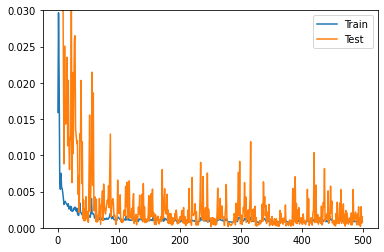

In [21]:
plt.plot(history.history['loss'], label= 'Train')
plt.plot(history.history['val_loss'], label= 'Test')
plt.legend()
plt.ylim(0, .03);

In [22]:
hr_test_results_sc = pd.DataFrame(X_test[win_length:])

In [23]:
hr_test_results_sc[2] = test_preds

In [24]:
hr_test_results_sc.head(10)

,0,1,2,3,4,5
0,0.027153,0.0,0.108159,0.0,0.050575,0.102258
1,0.027541,0.0,0.106901,0.0,0.050287,0.124834
2,0.027929,0.0,0.110782,0.0,0.050862,0.167331
3,0.028317,0.0,0.112202,0.0,0.051314,0.203187
4,0.028704,0.0,0.114363,0.0,0.051642,0.232404
5,0.029092,0.0,0.118461,0.0,0.052422,0.254980
6,0.029480,0.0,0.116249,0.0,0.053654,0.270916
7,0.029868,0.0,0.111457,0.0,0.055337,0.280212
8,0.030256,0.0,0.104464,0.0,0.057471,0.282869
9,0.030644,0.0,0.094948,0.0,0.059770,0.275786


In [25]:
# Column '4' is y_test predictions, de-scaled
hr_test_results = pd.DataFrame(mm_scaler.inverse_transform(hr_test_results_sc))
hr_test_results.head(10)

,0,1,2,3,4,5
0,72.0,0.0,518.444187,0.0,69.400000,16.100000
1,73.0,0.0,514.044200,0.0,69.375000,16.950000
2,74.0,0.0,527.617018,0.0,69.425000,18.550000
3,75.0,0.0,532.581188,0.0,69.464286,19.900000
4,76.0,0.0,540.137644,0.0,69.492857,21.000000
5,77.0,0.0,554.465242,0.0,69.560714,21.850000
6,78.0,0.0,546.731528,0.0,69.667857,22.450000
7,79.0,0.0,529.975147,0.0,69.814286,22.800000
8,80.0,0.0,505.525381,0.0,70.000000,22.900000
9,81.0,0.0,472.249694,0.0,70.200000,22.633333


In [26]:
# This is y_test, de-scaled (Original)
pd.DataFrame(test_df['Oxygen'][win_length:]).reset_index().drop('index', axis= 1)

,Oxygen
0,468.400000
1,475.875000
2,481.325000
3,491.878571
4,507.535714
...,...
2504,471.150000
2505,446.833333
2506,416.500000
2507,377.571429


In [27]:
pd.DataFrame(test_df['Power'][win_length:]).reset_index().drop('index', axis= 1) * .5

,Power
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
2504,0.0
2505,0.0
2506,0.0
2507,0.0


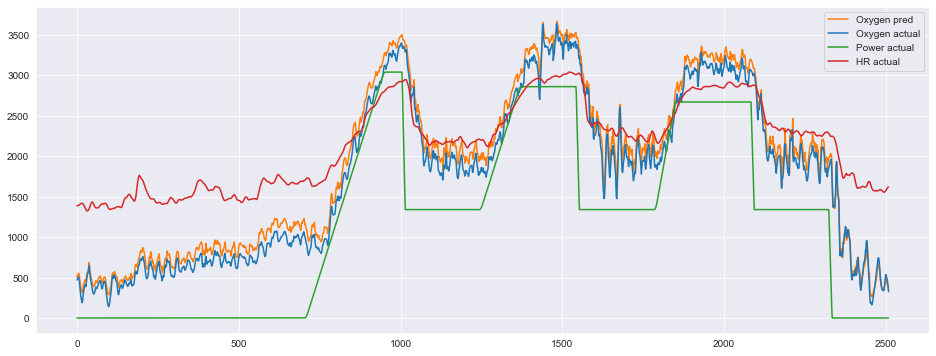

In [38]:
sns.set_style('darkgrid')

plt.figure(figsize= (16, 6))
plt.plot(hr_test_results[2], color = 'tab:orange', label= 'Oxygen pred')
plt.plot(pd.DataFrame(test_df['Oxygen'][win_length:]).reset_index().drop('index', axis= 1), color= 'tab:blue', label= 'Oxygen actual')
plt.plot(pd.DataFrame(test_df['Power'][win_length:]).reset_index().drop('index', axis= 1) * 10, color= 'tab:green', label= 'Power actual')
plt.plot(pd.DataFrame(test_df['HR'][win_length:]).reset_index().drop('index', axis= 1) * 20, color= 'tab:red', label= 'HR actual')
#plt.ylim(50, 160)
plt.legend();